In [4]:
data_dir = 'd:/Effusion_T/train'

In [5]:
import os

In [6]:
os.listdir(data_dir)

['Effusion', 'Normal']

In [7]:
from torchvision.datasets import ImageFolder

In [8]:
import torchvision.transforms as tt
from torch.utils.data import random_split
train_ds = ImageFolder(data_dir, tt.Compose([tt.Resize([64,64]), tt.RandomInvert(0.5) ,tt.ToTensor()]))

val_pct = 0.1
val_size = int(val_pct * len(train_ds))
train_size = len(train_ds) - val_size



train_ds, valid_ds = random_split(train_ds, [train_size, val_size])
len(train_ds), len(valid_ds)

(5654, 628)

In [9]:
len(train_ds), len(valid_ds)

(5654, 628)

In [10]:
img, label = train_ds[0]
print(img.shape, label)

torch.Size([3, 64, 64]) 1


In [11]:
from torch.utils.data.dataloader import DataLoader
batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

valid_dl = DataLoader(valid_ds, batch_size, num_workers=2, pin_memory=True)

In [16]:
for cls in os.listdir(data_dir):
  print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

NORMAL : 1342
PNEUMONIA : 3876


In [17]:
import torch.nn as nn
import torch.nn.functional as F
import torch

In [18]:
def get_default_device():
    if torch.cuda.is_available(): # Pick GPU if available, else CPU
        return torch.device('cuda')
    else:
        return torch.device('GPU')
    
def to_device(data, device):
    # Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)): 
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    #Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        #Yield a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        #Number of batches
        return len(self.dl)

In [19]:
device = get_default_device()
device

device(type='cuda')

In [20]:
# moves data to GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [21]:
# extending the nn.Module class
class ImageClassificationBase(nn.Module):
  def training_step(self, batch): # calculating loss for a batch of training data
    images, labels = batch
    out = self(images) # Pass images into the model and generates predictions
    loss = F.cross_entropy(out, labels) # Calculate loss using cross entropy
    return loss

  def validation_step(self, batch): # calculating loss and accuracy for a batch of validation data
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels) # Calculate loss using cross entropy
    acc = accuracy(out, labels) # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean() # Combine losses and take the mean
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean() # Combine accuracies and take the mean
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()} # Combine all results for the validation set

  def epoch_end(self, epoch, result): # will print all the information after each epoch
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
    
def accuracy(outputs, labels): # calculates accuracy of the predictions
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [22]:
@torch.no_grad() # tells pytorch to not compute gradients while in evaluation mode
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch) # takes a batch of data from the training set and returns the loss for that batch
            train_losses.append(loss)
            loss.backward() # calculates gradients
            optimizer.step() # performs gradient descent and update the weights of the model
            optimizer.zero_grad() # clears out gradients
        # Validation phase
        result = evaluate(model, val_loader) # go into evaluation mode
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [23]:
from torch.nn.modules.pooling import MaxPool2d

def conv_block(in_channels, out_channels, pool=False):
  # BatchNorm2d for regularization and reduce overfitting
        # applying activation function (ReLU) and introducing non-linearity
        # MaxPool2d takes each set of 4 pixels and replaces them with the max value
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ChestXrayModel_1(ImageClassificationBase): # extending ImageClassificationBase
    def __init__(self, in_channels, num_classes):
        super().__init__()
        

        # Input: 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 32) 
        self.conv2 = conv_block(32, 64, pool=True) # 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(64, 64), # 128 x 32 x 32
                                  conv_block(64, 64)) 
        
        self.conv3 = conv_block(64, 128, pool=True) # 256 x 16 x 16
        self.conv4 = conv_block(128, 256, pool=True) # 512 x 8 x 8
        self.res2 = nn.Sequential(conv_block(256, 256),  # 512 x 8 x 8
                                  conv_block(256, 256))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 512 x 1 x 1 
                                        nn.Flatten(), # 512 x 1; flattens the output feature map into a vector
                                        nn.Dropout(0.2),
                                        nn.Linear(256, num_classes))
        
        
    def forward(self, xb): # taking the input and adding it back to the output throughout the layers
        out = self.conv1(xb)
        out = self.conv2(out) # ouput becomes an input. 
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [24]:
model = to_device(ChestXrayModel_1(3, 2), device)
model

ChestXrayModel_1(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=T

In [ ]:
for batch in train_dl:
    images, labels = batch
    print('images.shape', images.shape)
    print('images.device', images.device)
    preds = model(images)
    print('preds.shape', preds.shape)
    print('preds[0]:', preds[0])
    break

In [ ]:
history = [evaluate(model, valid_dl)]
history

In [ ]:
import torch
import h5py

In [ ]:
torch.cuda.empty_cache()
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

In [ ]:
torch.save(model.state_dict(), 'c:/Users/tjoeun/Desktop/P3H5/model.pth')

In [ ]:
model_h5 = h5py.File('c:/Users/tjoeun/Desktop/P3H5/model.h5', 'w')
for key, value in model.state_dict().items():
    model_h5.create_dataset(key, data=value.cpu().numpy())
model_h5.close()

In [ ]:
import matplotlib.pyplot as plt
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_losses(history)

In [26]:
import torch
import h5py

# Load the model parameters from the H5 file
model_h5 = h5py.File('C:/Users/tjoeun/Desktop/P3H5/model.h5', 'r')
state_dict = {}
for key in model_h5.keys():
    state_dict[key] = torch.Tensor(model_h5[key][()])

model_h5.close()

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Move the loaded model to the desired device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [8]:
test_dataset = ImageFolder('d:/chest_xray/chest_xray/test', tt.ToTensor())

In [27]:
def predict_image(img, model, classes): # number of classes is 2: NORMAL and PNEUMONIA
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [28]:
train_ds.dataset.classes

['NORMAL', 'PNEUMONIA']

In [30]:
import matplotlib.pyplot as plt

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.11 GiB (GPU 0; 4.00 GiB total capacity; 2.29 GiB already allocated; 407.05 MiB free; 2.30 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

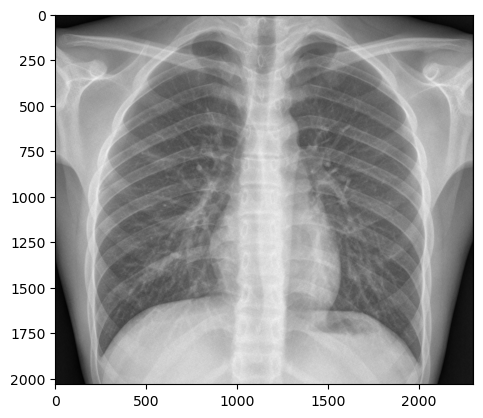

In [31]:
torch.cuda.empty_cache()
img, label = test_dataset[32]
plt.imshow(img.permute(1, 2, 0))
pred = predict_image(img, model, train_ds.dataset.classes)
print('Target:', train_ds.dataset.classes[label], ', Predicted:', pred)